# Установка PySpark

In [2]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=29acf37a9b48dcb1a2cd16ac4828c425cd1fbcd26e04cd4a61b34739bb2ca8b2
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


# Импорт необходимых инструментов

In [3]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import col, to_date, mean, month, year, when, avg, sum

# Чтение и обработка данных

In [4]:
# создание SparkSession
spark = SparkSession.builder.appName("WeatherAnalysis").getOrCreate()

# чтение CSV - файла
weather_df = spark.read.csv("/content/drive/MyDrive/weather_data.csv", header=True, inferSchema=True)

# преобразование колонки date в формат даты
weather_df = weather_df.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))

# замена пропущенных значений на средние значения по метеостанциям
mean_temp = weather_df.groupBy("station_id").agg(mean("temperature").alias("mean_temp"))
mean_precip = weather_df.groupBy("station_id").agg(mean("precipitation").alias("mean_precip"))
mean_wind = weather_df.groupBy("station_id").agg(mean("wind_speed").alias("mean_wind"))

weather_df = weather_df.join(mean_temp, on="station_id", how="left")
weather_df = weather_df.join(mean_precip, on="station_id", how="left")
weather_df = weather_df.join(mean_wind, on="station_id", how="left")

weather_df = weather_df.withColumn("temperature",
                                   when(col("temperature").isNull(), col("mean_temp")).otherwise(col("temperature")))
weather_df = weather_df.withColumn("precipitation",
                                   when(col("precipitation").isNull(), col("mean_precip")).otherwise(col("precipitation")))
weather_df = weather_df.withColumn("wind_speed",
                                   when(col("wind_speed").isNull(), col("mean_wind")).otherwise(col("wind_speed")))

# Удаление временных столбцов
weather_df = weather_df.drop("mean_temp", "mean_precip", "mean_wind")

weather_df.show(5)

+----------+----------+------------------+------------------+-----------------+
|station_id|      date|       temperature|     precipitation|       wind_speed|
+----------+----------+------------------+------------------+-----------------+
| station_7|2022-06-28|-6.751842212861652| 23.67004407474563|5.458999894629757|
| station_4|2020-04-07| -9.57484426026233|2.9858244485444665|6.828505392085966|
| station_8|2018-12-22| 19.34342035369938| 33.58211407730149|8.975576079892296|
| station_5|2021-09-09|30.880953114964086|29.110437988411558|18.26465360842913|
| station_7|2023-02-07|23.459048180599673|49.510444679381074|3.787868357696922|
+----------+----------+------------------+------------------+-----------------+
only showing top 5 rows



# Анализ данных

In [5]:

# топ-5 самых жарких дней
hottest_days = weather_df.orderBy(col("temperature").desc()) \
                         .select("date", "temperature").limit(5)
hottest_days.show()

# метеостанция с наибольшим количеством осадков за последний год
last_year = weather_df.filter(year("date") == 2023)
station_precip = last_year.groupBy("station_id") \
                          .agg(sum("precipitation").alias("total_precipitation")) \
                          .orderBy(col("total_precipitation") \
                          .desc()) \
                          .limit(1)
station_precip.show()

# средняя температура по месяцам
monthly_avg_temp = weather_df.withColumn("month", month("date")) \
                             .groupBy("month") \
                             .agg(avg("temperature").alias("average_temperature")) \
                             .orderBy("month")
monthly_avg_temp_data = monthly_avg_temp.collect()
monthly_avg_temp.show()

+----------+------------------+
|      date|       temperature|
+----------+------------------+
|2021-08-20|39.982828249354846|
|2023-12-02| 39.96797489293784|
|2022-03-28|  39.8246894248997|
|2019-02-11| 39.76737697836647|
|2020-06-10| 39.69147838355929|
+----------+------------------+

+----------+-------------------+
|station_id|total_precipitation|
+----------+-------------------+
| station_5|  642.9302626767898|
+----------+-------------------+

+-----+-------------------+
|month|average_temperature|
+-----+-------------------+
|    1| 11.356518462550754|
|    2|  9.067229891101926|
|    3|  7.244080205633994|
|    4| 12.024529009744693|
|    5|  9.902883346912718|
|    6| 13.421092297254138|
|    7| 6.1857183016954576|
|    8|   10.9678002814186|
|    9|  9.596744236573942|
|   10|   9.09884344821895|
|   11|  7.265889994697494|
|   12| 11.218592100674337|
+-----+-------------------+



# Визуализация

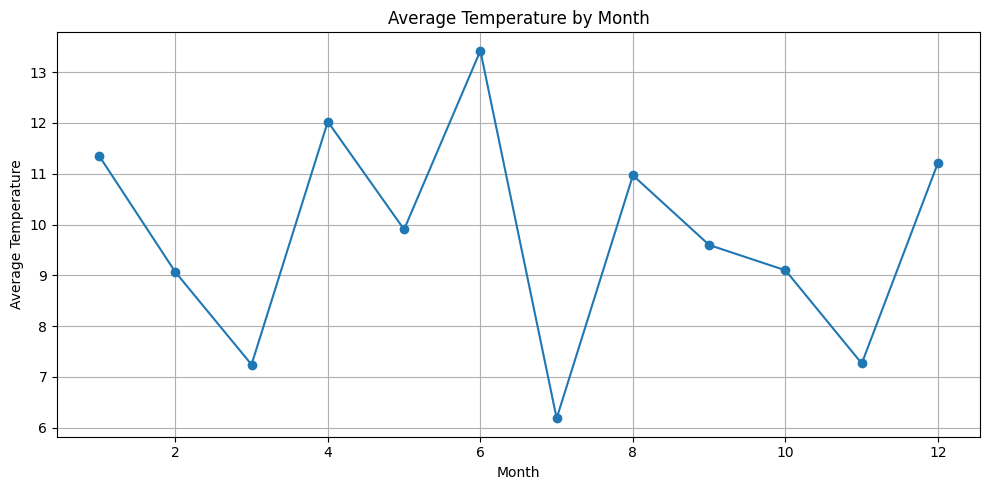

In [6]:
# Средняя температура по месяцам
months = [row["month"] for row in monthly_avg_temp_data]
average_temperatures = [row["average_temperature"] for row in monthly_avg_temp_data]

plt.figure(figsize=(10, 5))
plt.plot(months, average_temperatures, marker="o")
plt.xlabel("Month")
plt.ylabel("Average Temperature")
plt.title("Average Temperature by Month")
plt.grid(True)
plt.tight_layout()
plt.show()